In [1]:
import sys
sys.path.append('..')

import fiftyone as fo
from fiftyone import ViewField as F
# delete any tmp dataset
[fo.delete_dataset(d) for d in fo.list_datasets() if d.startswith("tmp_")]
fo.list_datasets()

['RGB_train_2023-03-28',
 'SAILING_28_06_2023_IR',
 'SAILING_DATASET',
 'SAILING_DATASET_QA',
 'SENTRY_VIDEOS_DATASET_QA',
 'TRAIN_THERMAL_DATASET_2023_06']

In [2]:
dataset_name = 'TRAIN_THERMAL_DATASET_2023_06'
try:
    dataset = fo.Dataset.from_dir(
        dataset_dir=f'/media/jigglypuff/NieuwVolume2/{dataset_name}',
        dataset_type=fo.types.FiftyOneDataset,
        name=dataset_name,
        persistent=True,
    )
except ValueError as e:
    print(e)
    print("Loading existing dataset")
    dataset = fo.load_dataset(dataset_name)

Dataset name 'TRAIN_THERMAL_DATASET_2023_06' is not available
Loading existing dataset


In [4]:
session = fo.launch_app(dataset, address="0.0.0.0", port=5050, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


## Compute uniqueness

In [5]:
if not dataset.has_field("uniqueness"):
    import fiftyone.brain as fob
    fob.compute_uniqueness(dataset)

## Annotated/noise (background) ratio

In [6]:
noise_ratio = 0.25

In [7]:
annotated = dataset.exists('ground_truth_det.detections', True)
noise = dataset.exists('ground_truth_det.detections', False)

n_noise = min(len(noise), int(len(annotated) * noise_ratio))
subset : fo.DatasetView = annotated + noise.sort_by("uniqueness", reverse=True).take(n_noise, seed=42)
session.view = subset

## Train/Val ratio 

In [8]:
val_ratio = 0.2
tags_suffix = 'v0'

In [9]:
# Split train/val based on trip
trip_counts = subset.count_values("trip")
# sort by count
trip_counts = dict(sorted(trip_counts.items(), key=lambda x: x[1], reverse=True))
# choose random trips with approximate specified val_ratio
val_trips = [trip for trip in list(trip_counts)[::int(1/val_ratio)]]

train_n = sum([x[1] for x in trip_counts.items() if x[0] not in val_trips])
val_n = sum([x[1] for x in trip_counts.items() if x[0] in val_trips])
total_n = train_n + val_n
print(f"Ratio train:val split: {train_n/total_n:.2f}:{val_n/total_n:.2f}")

Ratio train:val split: 0.76:0.24


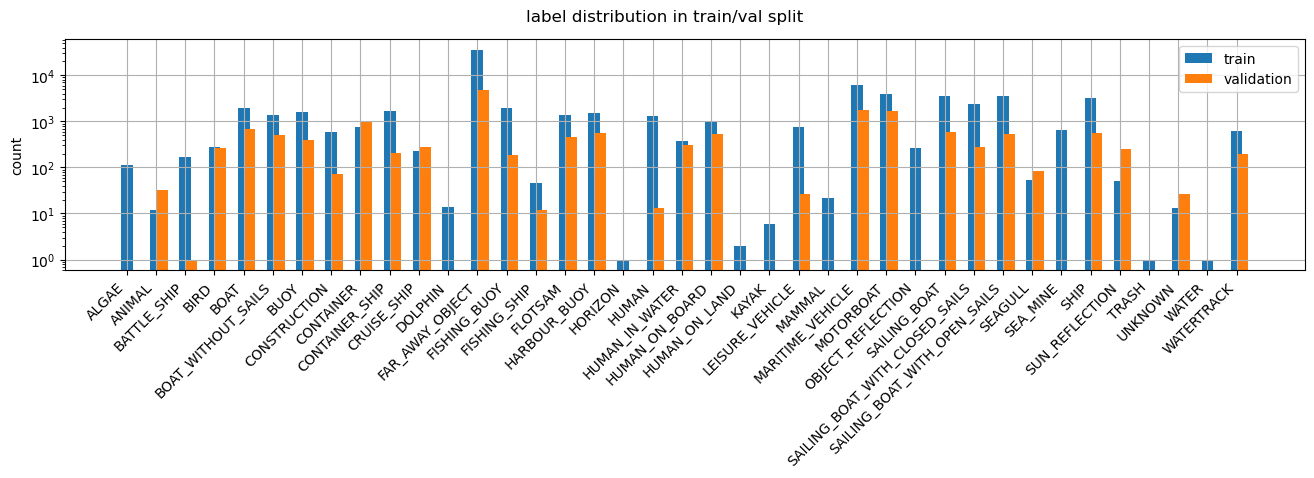

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(label_count_train: dict, label_count_val: dict):
    # add missing labels in val/train
    labels = set(label_count_train.keys()).union(set(label_count_val.keys()))
    label_count_train = {k: label_count_train.get(k, 0) for k in labels}
    label_count_val = {k: label_count_val.get(k, 0) for k in labels}

    # sort dicts by value
    label_count_train = dict(sorted(label_count_train.items(), key=lambda item: item[0]))
    label_count_val = dict(sorted(label_count_val.items(), key=lambda item: item[0]))

    # plot
    plt.figure(figsize=(16, 3))
    plt.suptitle("label distribution in train/val split")
    xaxis_train = np.arange(len(label_count_train.keys()))
    xaxis_val = xaxis_train+0.2
    plt.bar(xaxis_train, list(label_count_train.values()),label="train", width=0.4)
    plt.bar(xaxis_val, list(label_count_val.values()), label="validation", width=0.4)
    plt.yscale("log")
    plt.ylabel("count")
    plt.xticks(xaxis_train, list(label_count_train.keys()), rotation=45, ha="right")
    plt.legend()
    plt.grid()
    plt.show()

label_count_train = subset.match(~F("trip").is_in(val_trips)).count_values('ground_truth_det.detections.label')
label_count_val = subset.match(F("trip").is_in(val_trips)).count_values('ground_truth_det.detections.label')
plot_label_distribution(label_count_train, label_count_val)

In [11]:
subset.match(~F("trip").is_in(val_trips)).tag_samples(f"TRAIN_{tags_suffix}")
subset.match(F("trip").is_in(val_trips)).tag_samples(f"VAL_{tags_suffix}")

## Export to YOLO format

In [12]:
tmp_name = f'tmp_{dataset_name}'
try:
    export: fo.DatasetView = subset.clone(tmp_name)
except ValueError:
    print(f"Loading existing dataset {tmp_name}")
    export: fo.DatasetView = fo.load_dataset(tmp_name)

print("# detections (before filtering):", 
      len(export.values(f"ground_truth_det.detections[].label")))

# read class map
import yaml
with open('../data/class_map.yaml', 'r') as f:
    class_map = yaml.load(f, Loader=yaml.FullLoader)

# apply category map
export = export.map_labels("ground_truth_det", class_map)
export = export.filter_labels("ground_truth_det", F("label") != "None", only_matches=False)
export.keep()
export.save()

print("# detections (after fltering):", 
      len(export.values(f"ground_truth_det.detections[].label")))

# detections (before filtering): 94365
# detections (after fltering): 92869


In [13]:
# change filepaths to get raw 16-bit images for export
filepaths = export.values("filepath")
filepaths = [fp.replace("8Bit", "16Bit").replace("jpg", "png") for fp in filepaths]
export.set_values("filepath", filepaths)

In [14]:
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d")

export_dir=f"../datasets/{dataset_name}_{date}"

classes = export.distinct("ground_truth_det.detections.label")
fo_splits = [f"TRAIN_{tags_suffix}", f"VAL_{tags_suffix}"]
yolo_splits = ["train", "val"]
for fo_split, yolo_split in zip(fo_splits, yolo_splits):
    print("split:", fo_split)
    split = export.match_tags(fo_split) # .take(5000, seed=51)
    split.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="ground_truth_det",
        classes=classes,
        split=yolo_split,
    )

split: TRAIN_v0
 100% |█████████████| 31954/31954 [1.0h elapsed, 0s remaining, 6.8 samples/s]      
split: VAL_v0
Directory '../datasets/TRAIN_THERMAL_DATASET_2023_06_2023-10-04' already exists; export will be merged with existing files
 100% |█████████████| 10451/10451 [20.3m elapsed, 0s remaining, 7.5 samples/s]       


In [15]:
fo.delete_dataset(tmp_name)